In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True,exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url,tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
        return pd.read_csv('datasets/housing/housing.csv')
    
housing = load_housing_data()

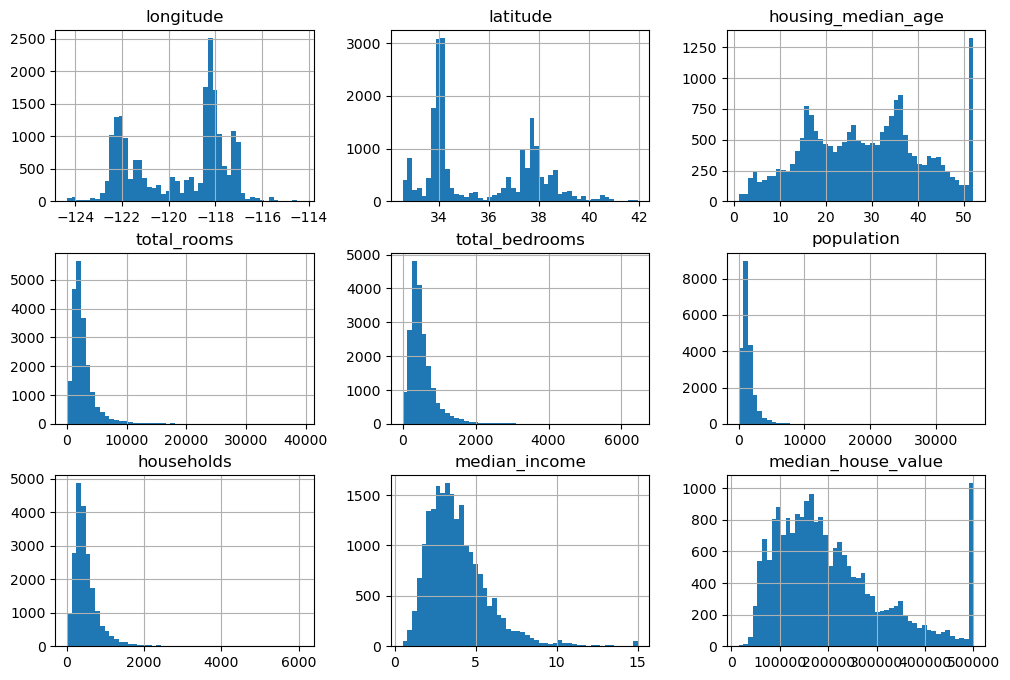

In [2]:
#분포를 확인할 때 describe대신 시각화해서 확인하는 법
import matplotlib.pyplot as plt

housing.hist(bins=50,figsize=(12,8))
plt.show()

In [3]:
#Data EDA를 할 때 꼭 지켜야할 것 : Test set를 분리해놓고 진행한다. 
#일반적으로는 셔플하고 나눈다. 하지만 그렇게 하면 분포별로 다른 비율이 들어가게 되므로 모델이 완벽해지지않는다. 
#이를 해결하기 위해서 stratifiedshufflesplit 을 사용한다.
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
#우선 target의 분포를 구해준다.
housing['income_cat'] = pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
splitter = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
strat_split = []
for train_idx, test_idx in splitter.split(housing,housing['income_cat']):
    strat_train_set = housing.iloc[train_idx]
    strat_test_set = housing.iloc[test_idx]
    strat_split.append([strat_train_set,strat_test_set])

print(strat_split)

[[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41     37.66                44.0        431.0           195.0   

       population  households  median_income  med

In [4]:
#위와 같이 계층적 샘플링을 할 수 있고, sklearn의 train_test_split()을 사용해서 간편하게 만들 수 있다.
from sklearn.model_selection import train_test_split 
strat_train_set,strat_test_set = train_test_split(housing,test_size=0.2,random_state=42,stratify=housing['income_cat'])

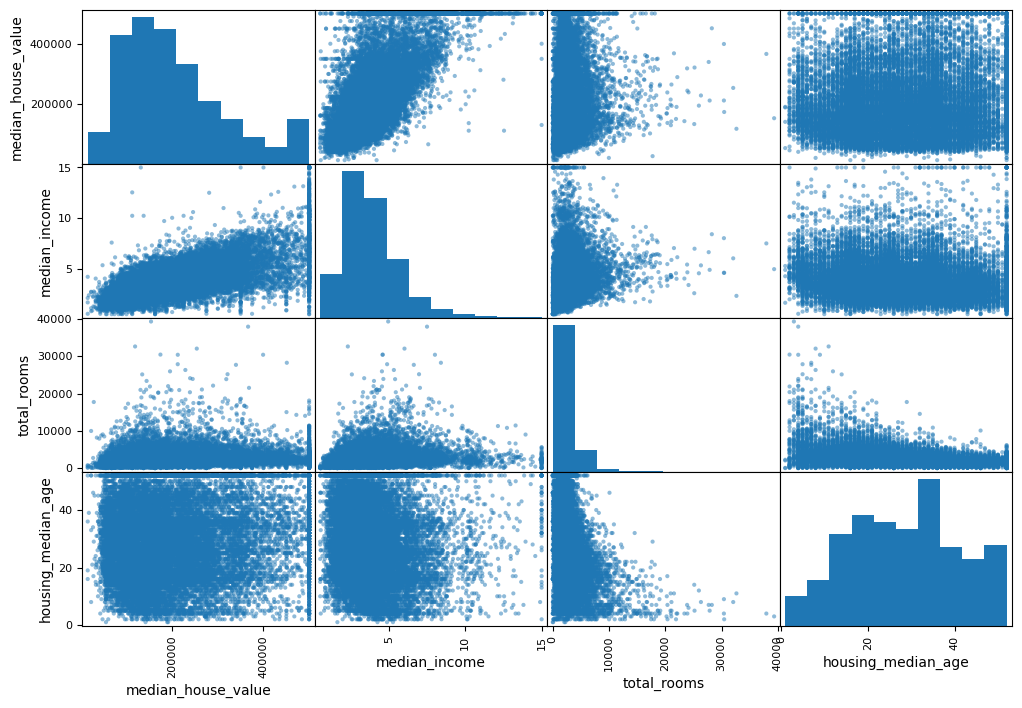

In [5]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

In [6]:
#위와같이 원하는 변수들끼리의 상관관계를 확인해볼 수 있다. 
#corr이나 heatmap이나 scatter plotting이나 상관관계를 확인해볼 수 있는 방법이지만 상관관계에만 집중하다보면 간과할 수 있는 부분이 있다.
#데이터들이 비선형적인 관계를 가질 때 상관관계 분석에서는 없다고 나오기 때문이다. 
#그러기 때문에 수치적으로만 볼 것이 아니라 비선형 관계를 가지고 있는지 꼭 시각화를 통해서 확인하는 것이 좋다.
#위에 데이터들에서는 일부분이 상한석이 정해져서 자연스럽지 않은 데이터 분포가 있는 것을 확인할 수 있다. 

#이번에는 머신러닝 알고리즘을 위해서 데이터 준비하는 과정을 자동화해보자.
housing = strat_train_set.drop("median_house_value",axis=1)
housing_label = strat_train_set['median_house_value'].copy()

In [7]:
#nan 값을 처리하는 방법
#1. dropna , 전체 drop, 누락된 값을 다른 방법으로 채우기 (이를 대체 imputation)이라고 부른다.
#데이터를 최대한 유지하는 옵션 3을 사용해보자.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
#중간값은 수치형 특성에만 계산될 수 있기 때문에 수치 특성만 가진 데이터 복사본을 생성한다.
housing_num = housing.select_dtypes(include=[np.number]) #select dtypes를 통해서 수치형 데이터만 고를 수 있다.


In [8]:
#설정한 수치형 데이터만 가지고 imputer에 적용할 수 있다.
imputer.fit(housing_num)
#imputer는 각 feature의 중간값을 계산해서 그 결과를 객체의 statistics_ 속성에 저장한다.
#현재는 total_bedrooms 특성에만 누락값이 있지만 나중에는 어떤 데이터에서 누락값이 발생할지 모르기 때문에 모든 수치형 특성에 imputer를 정의하는 것이 좋다.
print(imputer.statistics_)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [9]:
#학습된 imputer객체를 사용해서 바꾸자.
X = imputer.transform(housing_num)
#strategy='mean'말고 most_frequent라던지 constant를 통해서 바꿀 수 있다. 

In [10]:
#또한 sklearn imputer는 누락값을 대체하기 위한 다양한 클래스를 제공한다.
#KNNimputer 와 IterativeImputer가 있다. 전자는 knn 평균으로(모든 feature사용) 대체하는 것이고, iterativeimputer는 특성마다 회귀모델을 훈련해서 모든 feature를 기반으로 예측한다.

#이렇게 넘파이로 변환한 데이터를 다시 dataframe으로 변환하는 것은 어렵지 않다.
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [12]:
#텍스트와 범주형 특성을 다뤄보자. 
housing_cat = housing[['ocean_proximity']]
print(housing_cat)

      ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
...               ...
14207       <1H OCEAN
13105          INLAND
19301      NEAR OCEAN
19121       <1H OCEAN
19888      NEAR OCEAN

[16512 rows x 1 columns]


In [13]:
# 이 특성은 범주형 특성이다. 따라서 onehot encoding이나 oridinary encoding을 통해서 변환할 수 있다. 
from sklearn.preprocessing import OrdinalEncoder
or_enc = OrdinalEncoder()
housing_cat_encoded = or_enc.fit_transform(housing_cat)
print(housing_cat_encoded)

[[3.]
 [0.]
 [1.]
 ...
 [4.]
 [0.]
 [4.]]


In [14]:
#특성들의 스케일링 
#특성들의 스케일이 많이 다르면 모델이 잘 작동하지 않는다. 
#따라서 범위를 비슷하게 해주는 min-max 스케일링이나 표준화(standardization)을 사용한다. 
#min max는 범위가 제한되지만, 표준화는 범위로 제한하지 않는다. 하지만 표준화는 이상치에 영향을 덜 받는다. 
#만약에 데이터의 분포가 한쪽으로 쏠려있는 경우 바로 정규화 표준화를 진행하는 것보다 특성을 log화해서 분포를 조절하는 것이 더 좋다.
#이것은 회귀 목표인 target의 값에도 똑같이 적용할 수 있다. 


In [17]:
from sklearn.preprocessing import FunctionTransformer
log_trans = FunctionTransformer(np.log,inverse_func=np.exp)
log_pops = log_trans.transform(housing[['population']])

In [18]:
print(log_pops) 

       population
13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
...           ...
14207    6.843750
13105    7.257708
19301    7.942362
19121    7.452982
19888    6.525030

[16512 rows x 1 columns]


In [19]:
from sklearn.metrics.pairwise import rbf_kernel
rbf_trans = FunctionTransformer(rbf_kernel,kw_args=dict(Y=[[35.]],gamma=0.1))
age_simil_35 = rbf_trans.transform(housing[['housing_median_age']])

In [20]:
print(age_simil_35)

[[2.81118530e-13]
 [8.20849986e-02]
 [6.70320046e-01]
 ...
 [9.55316054e-22]
 [6.70320046e-01]
 [3.03539138e-04]]


In [21]:
#사이킷런에서는 올바른 순서대로 데이터 변환을 처리해주는 pipeline 클래스를 제공한다. 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('standardize',StandardScaler()),
])

#이렇게 이름을 지정하기 귀찮다면 make_pipeline을 사용하자
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
#다음 fit/transform, fit_transform을 사용하면 실행된다. 

housing_num_prepared = num_pipeline.fit_transform(housing_num)
print(housing_num_prepared)

[[-1.42303652  1.0136059   1.86111875 ...  0.13746004  1.39481249
  -0.93649149]
 [ 0.59639445 -0.702103    0.90762971 ... -0.69377062 -0.37348471
   1.17194198]
 [-1.2030985   1.27611874  0.35142777 ... -0.78876841 -0.77572662
  -0.75978881]
 ...
 [ 1.25620853 -1.42870103 -1.23772062 ...  1.26829911  0.67913534
   0.1010487 ]
 [ 0.58639727 -0.73960483  0.66925745 ...  0.27356264  0.88286825
   0.14539615]
 [-1.41803793  0.94797769  1.22545939 ... -0.67915557 -0.75221898
  -0.31034135]]


In [25]:
#지금까지 범주형 열과 수치형 열을 각각 다루었다. 하나의 변환기로 각 열마다 적절한 변환을 적용하면 더 편리할 것 같다.
#ColumnTransformer로 변환할 수 있다. 
from sklearn.compose import ColumnTransformer
num_att = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
cat_att = ['ocean_proximity']
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([("num",num_pipeline,num_att),
                                  ("cat",cat_pipeline,cat_att)])

In [26]:
#모든 특성이름을 하나하나 나열하는 것은 귀찮을 수 있기 때문에 적절한 타입을 자동으로 선택해주는 make_column_selector를 제공한다.
#이것을 특성 이름이나 인덱스 대신 ColumnTransformer에 전달할 수 있다. 
from sklearn.compose import make_column_selector,make_column_transformer
preprocessing = make_column_transformer(
    (num_pipeline,make_column_selector(dtype_include=np.number)),
    (cat_pipeline,make_column_selector(dtype_include=object))
)
#이로서 완전히 편해진다.


In [27]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear_reg = make_pipeline(preprocessing,linear)
linear_reg.fit(housing,housing_label)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000270FB6FF610>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027081F49CD0>)])),
                ('linearregression', LinearRegression())])

In [28]:
pred = linear_reg.predict(housing)
print(pred)

[270886.93228264 334830.60618945 119856.18008898 ... 195962.32147342
 283097.58349723 233352.27953643]


In [29]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(housing_label,pred,squared=False)
print(lin_mse)

68232.83515124217
